In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load data

In [2]:
bbar = pickle.load(open("./cache/tng100_bbar.pkl", "rb"))
tbar = pickle.load(open("./cache/tng100_tbar.pkl", "rb"))
bdmo = pickle.load(open("./cache/tng100_bdmo.pkl", "rb"))
tdmo = pickle.load(open("./cache/tng100_tdmo.pkl", "rb") )
matches = pickle.load(open("./cache/matches.pkl", "rb") )

# Preliminary Look at the data

(array([2.097e+03, 1.099e+03, 4.840e+02, 2.070e+02, 9.000e+01, 3.600e+01,
        1.300e+01, 4.000e+00, 1.000e+00, 7.000e+00]),
 array([11.50004768, 11.7939415 , 12.08783531, 12.38172817, 12.67562199,
        12.9695158 , 13.26340961, 13.55730343, 13.85119629, 14.1450901 ,
        14.43898392]),
 <BarContainer object of 10 artists>)

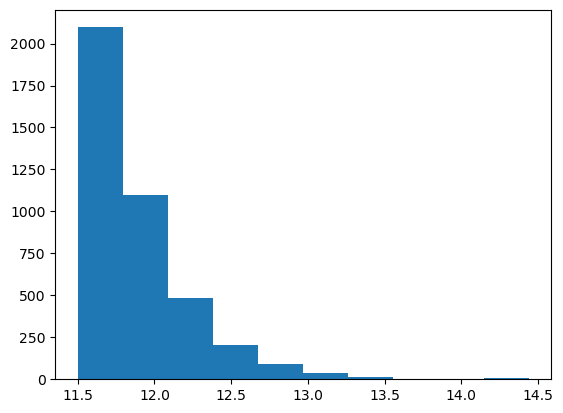

In [17]:
plt.hist(np.log10(bbar['mpeak_pre']))

3240


(array([  2., 569., 934., 484., 291., 228., 179., 202., 152., 199.]),
 array([10.94937611, 11.30794334, 11.66651058, 12.02507782, 12.38364506,
        12.7422123 , 13.10077858, 13.45934582, 13.81791306, 14.17648029,
        14.53504753]),
 <BarContainer object of 10 artists>)

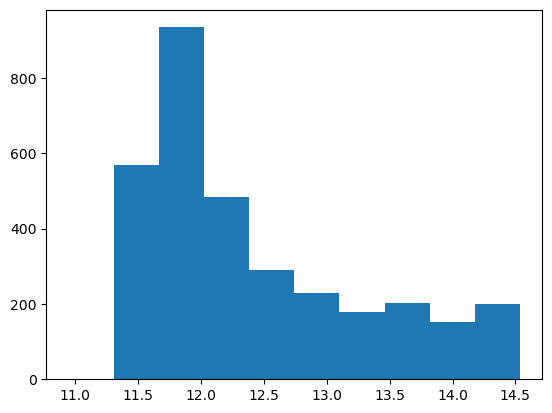

In [14]:
mvir = tbar['mvir'][:, -1] 
mvir = mvir[mvir > 0] 
print(len(mvir))
plt.hist(np.log10(mvir))

# Perform matching and look at trees

In [3]:
len(matches), len(tdmo), len(tbar), tdmo['mvir'].shape, 

(4038, 19049, 4038, (19049, 100))

In [4]:
# percentage of matches (baryons
len(matches[matches!=-1]) / len(matches) 

0.8093115403665181

In [5]:
# extract haloes and MAHs within given present-day mass range
# with no errors, exist in present day and matches with DMO 
mah_dmo = [] 
mah_bar = []
dmo_id = [] 
bar_id = []

# questions: 

for ii in tqdm(range(len(tbar))):
    match = matches[ii]
    if match != -1: 
        
        # TODO: TAKE mah upto infall snap and keep it constant after 
        
        ok_dmo = ~bdmo['is_err'][match]
        ok_bar = ~bbar['is_err'][ii]
        
        mvir_dmo = tdmo['mdm'][match]
        mvir_bar = tbar['mdm'][ii]
        assert mvir_dmo.shape == (100,)
        dmo_mah = np.log10(mvir_dmo, out=np.zeros_like(mvir_dmo), where=(mvir_dmo!=0))
        bar_mah = np.log10(mvir_bar, out=np.zeros_like(mvir_bar), where=(mvir_bar!=0))

        # extract id (present)
        dmo_subfind_id = tdmo['subfind_id'][match, -1]
        bar_subfind_id = tbar['subfind_id'][ii, -1]

        
        # should also check if halo exists in present day
        mpeak_pre_dmo = np.log10(bdmo['mpeak_pre'][match])
        mpeak_pre_bar = np.log10(bbar['mpeak_pre'][ii])
        
        is_cut_dmo = (mpeak_pre_dmo > 11) & ( mpeak_pre_dmo < 12) & (tdmo['mvir'][match,-1] > 0)
        is_cut_bar = (mpeak_pre_bar > 11) & ( mpeak_pre_bar < 12) & (tbar['mvir'][ii,-1] > 0)
        
        if ok_dmo & is_cut_dmo & ok_bar & is_cut_bar:
            mah_dmo.append(dmo_mah)
            mah_bar.append(bar_mah)
            dmo_id.append(dmo_subfind_id)
            bar_id.append(bar_subfind_id)



100%|██████████| 4038/4038 [00:00<00:00, 29240.51it/s]


In [6]:
# Questions (April 25, 2024) 
# * Check the cuts I should be using? 
# * we need present mass to be non-zero right?

In [7]:
# stack them into arrays
_mah_dmo = np.concatenate([m.reshape(1, 100) for m in mah_dmo], axis=0)
_mah_bar = np.concatenate([m.reshape(1, 100) for m in mah_bar], axis=0)
_dmo_id = np.array(dmo_id)
_bar_id = np.array(bar_id)

_mah_dmo.shape, _mah_bar.shape, _dmo_id.shape, _bar_id.shape

((1707, 100), (1707, 100), (1707,), (1707,))

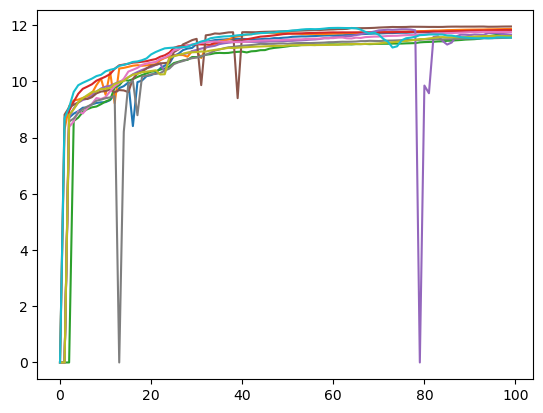

In [8]:
# plot some random trees
indices = np.random.choice(list(range(len(_mah_dmo))), size=10)
for t in _mah_dmo[indices]:
    plt.plot(t)

# NOTES
# * snapshots thart are valid are those with non-zero mass (subfind has problem where it can miss a snapshot)
# * mass switches -->>> sudden rises, halo falls into a much larger halo and could become a splashback halo, in the next snapshot the central 
# host mass jump at merger time, could be Group_M_Top_Hat200; or mass switches
# * what is the mass used? 
# 'mvir' -> group mass 
# 'mdm' -> subhalo mass
# 'mpeak_pre' -> calculate from mvir ; prior to infall

# keep mpeak what it was before infall

# TODO: remove snapshots from trees where it falls to 0 or interpolate

# Look at all MAHs and see if non-matches occupy some interesting space

In [9]:
# we can look at definitions of formation time

In [10]:
mdm_bar = tbar['mdm']
bar_mah = np.log10(mdm_bar, out=np.zeros_like(mdm_bar), where=(mdm_bar!=0))
bar_mah.shape, matches.shape

((4038, 100), (4038,))

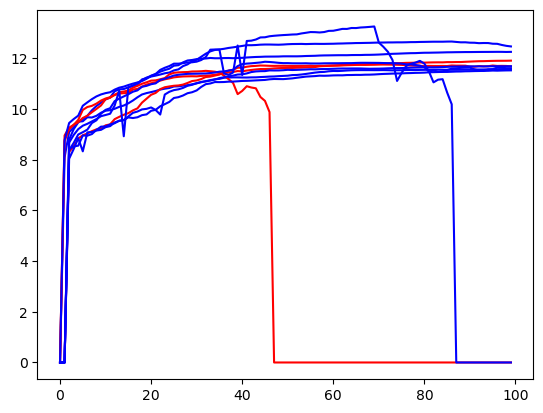

In [24]:
# plot some random trees
indices = np.random.choice(list(range(len(bar_mah))), size=10)
for idx in indices:
    t = bar_mah[idx]
    is_match = matches[idx] != -1
    plt.plot(t, color='b' if is_match else 'r')

# NOTES

In [170]:
# of present with matches and without matches
is_present = bar_mah[:, -1] > 0
is_match = matches != -1
print(len(bar_mah[is_match & is_present]) / len(bar_mah[is_present]), len(bar_mah[~is_match & is_present]) / len(bar_mah[is_present]))
print(len(bar_mah[is_match]) / len(bar_mah))
# thus we can look just at haloes that 'are present' formation time to see if there is a bias in the MAHs based on selection.

0.812962962962963 0.18703703703703703
0.8093115403665181


In [192]:
is_present = mdm_bar[:, -1] > 0
mdm_bar_p = mdm_bar[is_present]
form_snaps = [] 
for ii in range(len(mdm_bar_p)):
    mah = mdm_bar_p[ii]
    form_snaps.append(np.argwhere(mah > mah[-1] * 0.5)[0].item())


form_snaps = np.array(form_snaps)

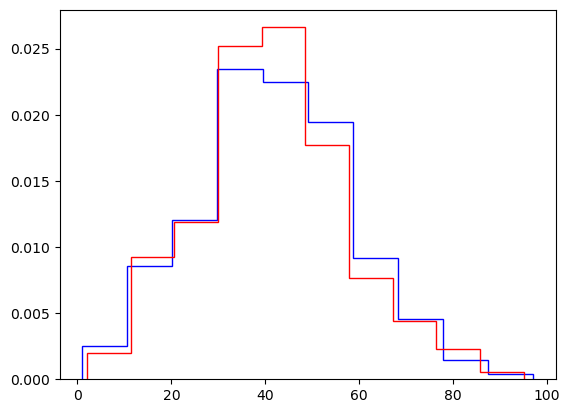

In [199]:
mask1 = (is_present & is_match)[is_present]
mask2 = (is_present & ~is_match)[is_present]

_, bins, _ = plt.hist(form_snaps[mask1], color='b', histtype='step', density=True) 
_, bins, _ = plt.hist(form_snaps[mask2], color='r', histtype='step', density=True) 

# Add additinal information 

In [201]:
_bar_id # we can use this to match with the rest of the information!

array([ 31366,  31368,  31376, ..., 563783, 569305, 571094])

# Read TNG Snapshots and combine information

In [12]:
# read tng snapshots
snap1= "/nfs/turbo/lsa-cavestru/imendoza/TNG10"

In [15]:
import h5py
f = h5py.File(snap1,'r')

In [30]:
f.keys()

<KeysViewHDF5 ['Config', 'Header', 'Parameters', 'PartType0', 'PartType1', 'PartType3', 'PartType4', 'PartType5']>

In [42]:
f['Header']

<HDF5 group "/Header" (0 members)>

In [13]:
from astropy.io.misc.hdf5 import read_table_hdf5
read_table_hdf5(snap1)

ValueError: no table found in HDF5 group None

In [ ]:
Table.re

In [56]:
len(dmo_id)

145

In [52]:
sum(matches!=-1), len(matches)

(307653, 813083)

In [45]:
mvir = tdmo['mvir'][:, -1]
sum((mvir>0) & (np.log10(bdmo['mpeak_pre']) > 11) & (np.log10(bdmo['mpeak_pre']) < 12) & (~bdmo['is_err']))

/tmp/ipykernel_1143108/3116376147.py:2: RuntimeWarning: divide by zero encountered in log10
  sum((mvir>0) & (np.log10(bdmo['mpeak_pre']) > 11) & (np.log10(bdmo['mpeak_pre']) < 12) & (~bdmo['is_err']))


1795

In [53]:
mvir = tbar['mvir'][:, -1]
sum((mvir>0) & (np.log10(bbar['mpeak_pre']) > 11) & (np.log10(bbar['mpeak_pre']) < 12) & (~bbar['is_err']) &(matches!=-1))

/tmp/ipykernel_1143108/959766558.py:2: RuntimeWarning: divide by zero encountered in log10
  sum((mvir>0) & (np.log10(bbar['mpeak_pre']) > 11) & (np.log10(bbar['mpeak_pre']) < 12) & (~bbar['is_err']) &(matches!=-1))


1538

In [8]:
host_bar = np.argmax(bbar["mpeak"])


In [11]:
bbar['mpeak'].shape

(813083,)

In [7]:
bdmo['mpeak_pre'].shape, tdmo['mvir'].shape, matches.shape, bbar['mpeak_pre'].shape, tbar['mvir'].shape

((760824,), (760824, 100), (813083,), (813083,), (813083, 100))

In [6]:
matches

array([6841,   -1,   -1, ...,   -1,   -1,   -1])

In [35]:
tdmo['mvir'][10].shape

(100,)

/tmp/ipykernel_1886444/4269425887.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(tdmo['mvir'][200]))


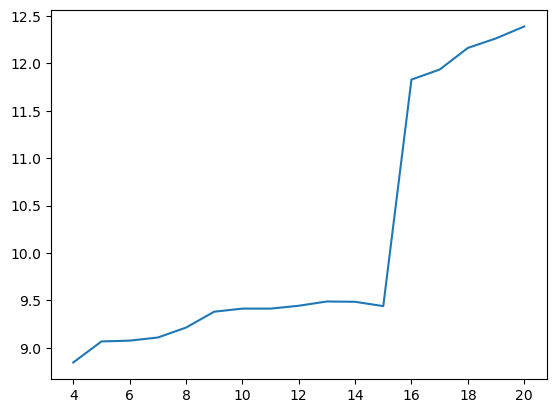

In [37]:
plt.plot(np.log10(tdmo['mvir'][200]))

In [15]:
mpeak_pre = bdmo['mpeak_pre'] 

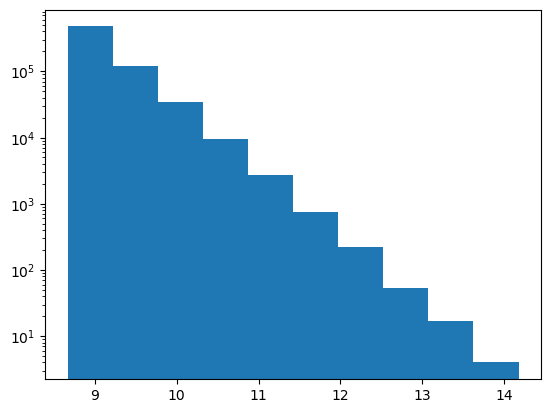

In [30]:
_mpeak_pre = np.log10(mpeak_pre[mpeak_pre > 0])
plt.hist(_mpeak_pre)
plt.yscale('log')

In [26]:
np.percentile(mpeak_pre, 20)

513575904.0